In [3]:
import platform
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

warnings.filterwarnings(action='ignore')


In [50]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'
        self.df['효능_Morps'] = self.df['효능'].map(lambda x: self.getMorps(x))
        self.df['효능_NV'] = self.df['효능_Morps'].map(lambda x: self.getNV(x))
        self.df['효능_N'] = self.df['효능_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['효능_count_topn_NV']  = self.df['효능_NV'].map(lambda x: self.counter(x,n)) 
        self.df['효능_count_topn_N']  = self.df['효능_N'].map(lambda x: self.counter(x,n)) 

    def result(self,idx, top , dis):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫' '치료', '쉼' ,'극복' , '재활', '--']
        cycle = ['돌', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗', '해소', '--']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        effs_dims =  [energy, recovery, cycle , pury]
        sNV = self.df['효능_NV'][idx]

        result = []
        for dim in effs_dims:
            ab = []
            for sim_word in dim:
                sub = []
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
                ab.append(sub)
                aab = np.array(ab).flatten().tolist()
            aab = np.array(sorted(aab,reverse=True))[:top].mean()
            result.append(aab)
        
        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]
            std = np.std(result)
            
            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 유사어')
            plt.xticks(np.arange(len(effs_dims_name)), effs_dims_name)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
#            print(f'{word}s std is {std}' )
        return result
        
    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_idx,figsize):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫' '치료', '쉼' ,'극복' , '재활', '--']
        cycle = ['돌', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗', '해소', '--']        
        all_dims = energy + recovery + cycle + pury
        #effs_dims_name = ['에너지', '회복', '순환', '정화']

        plt.rc('font', family=self.font)
        sents = self.df['효능_NV'][emotion_idx]
        print(sents)
        
        result = []
        for word in sents:
            sub = []
            for dim_word in all_dims:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim_word , word))
                except:
                    sub.append(0)
            result.append(sub)

        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        em_name = self.df['감정'][emotion_idx]
        plt.title(f'{em_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(all_dims)),all_dims)
        plt.yticks(np.arange(len(sents)),sents)
        plt.show()
              
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def count_to_csv(self,file_name):
        em_name = ['행복' , '열정' , '두려움', '분노' , '우울' , '슬픔']
        em_idx = []
        for em in em_name:
            em_idx.append(em)
            em_idx.append(em + "count")
            em_idx.append(em + 'sims')
        
        em_dict = []
        max =  0
        for idx in range(0,5):
            vv = len(collections.Counter(self.df['therapy_NV'][idx]).items())
            if max < vv:
                max = vv

        ret_df = pd.DataFrame(em_dict,columns=em_idx)
        
        for idx in range(0,len(em_idx),3):
            tmp = sorted(collections.Counter(self.df['therapy_NV'][round(idx/3)]).items(), key = lambda item : item[1], reverse=True)
            tmp_words = []
            tmp_counts = []
            tmp_sims = []
            for x, y in tmp:
                tmp_words.append(x)
                tmp_counts.append(y)
                try:
                    tmp_sims.append(self.wiki_model.wv.similarity(x,em_idx[idx]))
                except:
                    tmp_sims.append(0)
            for _ in range(0,max - len(tmp)):
                tmp_words.append("")
                tmp_counts.append(0)
                tmp_sims.append(0)
                
            ret_df[em_idx[idx]] = tmp_words
            ret_df[em_idx[idx+1]] = tmp_counts
            ret_df[em_idx[idx+2]] = tmp_sims
        ret_df.to_csv(file_name)
        return ret_df
                
    def sim_word_to_csv(self,topn,file_name):
        em_name = ['행복','Similarity', '열정','Similarity', '두려움', 'Similarity', '분노','Similarity', '우울','Similarity', '슬픔','Similarity']
        em_dict = []
        
        ret_df = pd.DataFrame(em_dict,columns=em_name)
        for idx in range(0,len(em_name),2):
            
            tmp = self.wiki_model.wv.most_similar(em_name[idx],topn=topn)
            tmp_simwords = []
            tmp_Similarity = []
            
            for x , y in tmp:
                tmp_simwords.append(x)
                tmp_Similarity.append(y)
            
            ret_df[em_name[idx]] = tmp_simwords
            ret_df[em_name[idx+1]] = tmp_Similarity
        ret_df.to_csv(file_name)
        return ret_df
    
    def todf(self,topn, file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['감정'][idx])
            est = self.result(idx,topn,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

In [12]:
# 감정 데이터 확인
h_data = pd.read_csv("../data/emotion_data_hand_craft.csv")
h_data

,감정,효능
0,행복,음미 낙관 느낌 생각 즐기다
1,우울,행동 도움 생활 치료 명상
2,슬픔,사랑 도움 가족 시간 활동
3,열정,상기 집중 노력 몰입 휴식
4,분노,정지 회피 긍정 마음 호흡
5,두려움,직면 변화 대화 집중 용기


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


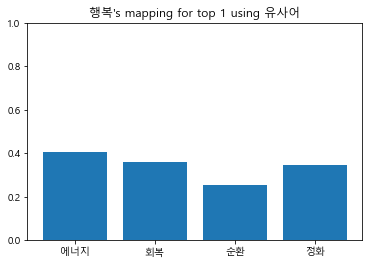

['음미', '낙관', '느낌', '생각', '즐기다']


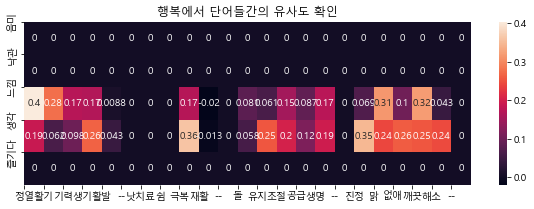

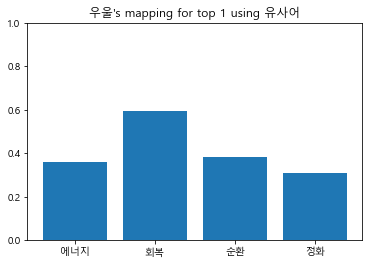

['행동', '도움', '생활', '치료', '명상']


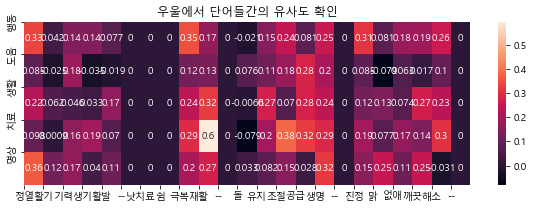

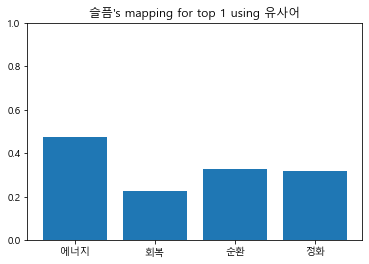

['사랑', '도움', '가족', '시간', '활동']


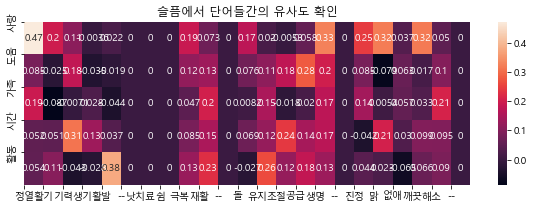

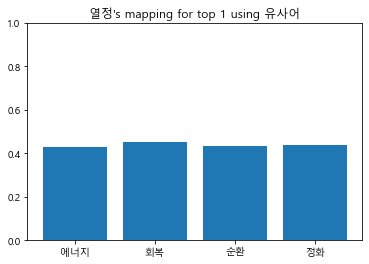

['상기', '집중', '노력', '몰입', '휴식']


C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


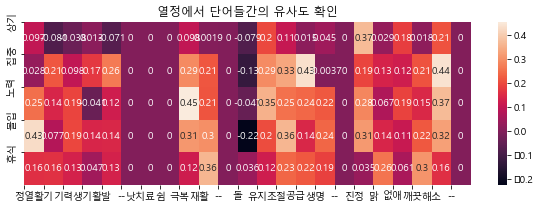

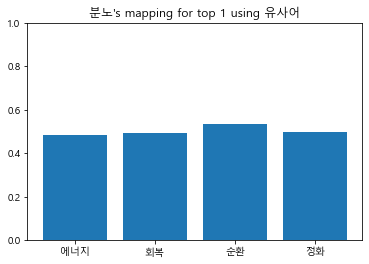

['정지', '회피', '긍정', '마음', '호흡']


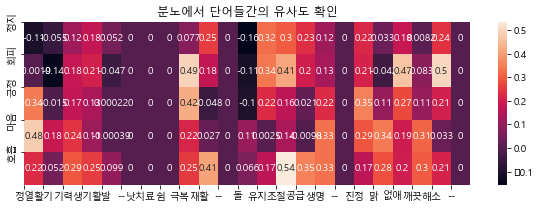

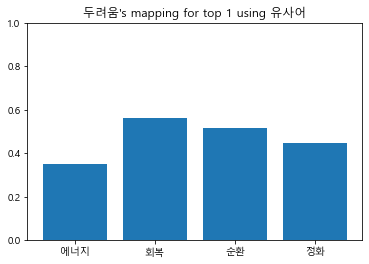

['직면', '변화', '대화', '집중', '용기']


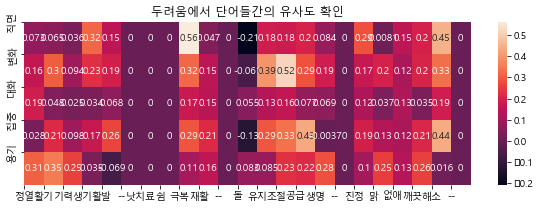

In [55]:
# 수치화가 제대로 되었는지 확인
# 상위 1개의 평균 이용
hXYZ = check_data(h_data)
for i in h_data.index:
    hXYZ.result(i,1,True)
    hXYZ.get_heatmap(i, (10,3))

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


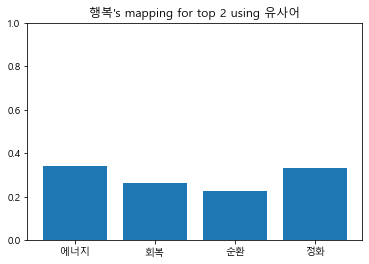

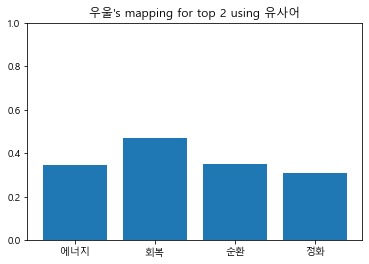

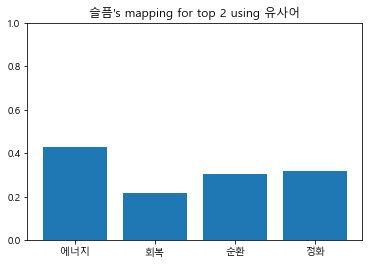

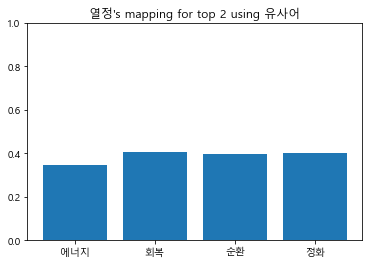

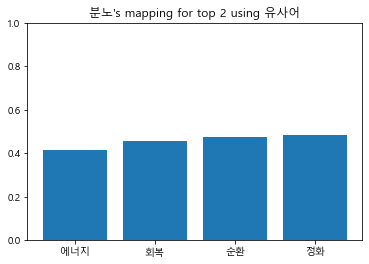

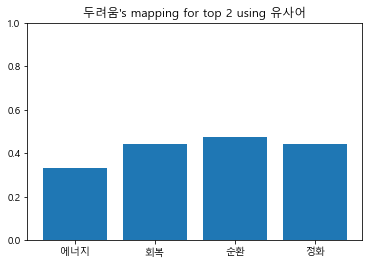

In [52]:
# 상위 2개의 평균 확인
hXYZ = check_data(h_data)
for i in h_data.index:
    hXYZ.result(i,2,True)
    #hXYZ.get_heatmap(i, (10,3))

In [57]:
# 상위 2개 평균 사용
# 상위 N개에서 N이 커질 수록 각 데이터의 차이가 줄어듬
# 현재 사용하는 데이터도 라벨링이 되어 있어서 상위 2개 정도만 사용하면 될 것 같음
hXYZ.todf(2,'../result/emotion_estimation.csv')

,감정,에너지,회복,순환,정화
0,행복,0.339845,0.264405,0.228558,0.332344
1,우울,0.346771,0.472084,0.350055,0.307193
2,슬픔,0.426716,0.216250,0.303326,0.318329
3,열정,0.345846,0.406059,0.396388,0.401650
4,분노,0.413446,0.457544,0.475200,0.482633
5,두려움,0.333882,0.440799,0.474286,0.441280
